Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

### Colab

Try this notebook on [Colab](http://colab.research.google.com/github/salesforce/ai-economist/blob/master/tutorials/multi_agent_gpu_training_with_warp_drive.ipynb).

# ⚠️ PLEASE NOTE:
This notebook runs on a GPU runtime.\
If running on Colab, choose Runtime > Change runtime type from the menu, then select `GPU` in the 'Hardware accelerator' dropdown menu.

# Introduction

Welcome! In this tutorial, we detail how we train multi-agent economic simulations built using [Foundation](https://github.com/salesforce/ai-economist/tree/master/ai_economist/foundation) and train it using [WarpDrive](https://github.com/salesforce/warp-drive), an open-source library we built for extremely fast multi-agent reinforcement learning (MARL) on a single GPU. For the purposes of exposition, we specifically consider the [COVID-19 and economy simulation](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/scenarios/covid19/covid19_env.py). The COVID-19 and economy is a simulation to model health and economy dynamics amidst the COVID-19 pandemic and comprises 52 agents.

We put together this tutorial with these goals in mind:
- Describe how we train multi-agent simulations from scratch, starting with just a Python implementation of the environment on a CPU.
- Provide reference starting code to help perform extremely fast MARL training so the AI Economist community can focus more towards contributing multi-agent simulations to Foundation.

We will cover the following concepts:
1. Building a GPU-compatible environment.
2. CPU-GPU environment consistency checker.
3. Adding an *environment wrapper*.
4. Creating a *trainer* object, and perform training.
5. Generate a rollout using the trainer object and visualize it.

### Prerequisites
It is helpful to be familiar with [Foundation](https://github.com/salesforce/ai-economist/tree/master/ai_economist/foundation), a multi-agent economic simulator, and also the COVID-19 and Economic simulation ([paper here](https://arxiv.org/abs/2108.02904)). We recommend taking a look at the following tutorials:

- [Foundation: the Basics](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb)
- [Extending Foundation](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_advanced.ipynb)
- [COVID-19 and Economic Simulation](https://github.com/salesforce/ai-economist/blob/master/tutorials/covid19_and_economic_simulation.ipynb)

It is also important to get familiarized with [WarpDrive](https://github.com/salesforce/warp-drive), a framework we developed for extremely fast end-to-end reinforcement learning on a single GPU. We also have a detailed tutorial on on how to [create custom environments](https://github.com/salesforce/warp-drive/blob/master/tutorials/tutorial-4-create_custom_environments.md) and integrate with WarpDrive.

# Dependencies

You will need to install the [AI Economist](https://github.com/salesforce/ai-economist) and [WarpDrive](https://github.com/salesforce/warp-drive) pip packages.

In [ ]:
import os, signal, sys, time
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/salesforce/ai-economist.git

    %cd ai-economist
    !pip install -e .
    
    # Restart the Python runtime to automatically use the installed packages
    print("\n\nRestarting the Python runtime! Please (re-)run the cells below.")
    time.sleep(1)
    os.kill(os.getpid(), signal.SIGKILL)
else:
    !pip install ai-economist

In [1]:
# Ensure that a GPU is present.
import GPUtil
num_gpus_available = len(GPUtil.getAvailable())
assert num_gpus_available > 0, "This notebook needs a GPU machine to run!!"

In [2]:
!pip install rl-warp-drive==1.5

In [2]:
import ai_economist
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from datetime import timedelta
from timeit import Timer

from ai_economist.foundation.scenarios.covid19.covid19_env import (
    CovidAndEconomyEnvironment,
)
from ai_economist.foundation.env_wrapper import FoundationEnvWrapper

from warp_drive.env_cpu_gpu_consistency_checker import EnvironmentCPUvsGPU
from warp_drive.training.trainer import Trainer
from warp_drive.training.utils.data_loader import create_and_push_data_placeholders
from warp_drive.utils.env_registrar import EnvironmentRegistrar

_PATH_TO_AI_ECONOMIST_PACKAGE_DIR = ai_economist.__path__[0]

# Set font size for the matplotlib figures
plt.rcParams.update({'font.size': 22})

Inside covid19_components.py: 1 GPUs are available.
Inside covid19_env.py: 1 GPUs are available.
Inside env_wrapper.py: 1 GPUs are available.


In [3]:
# Set logger level e.g., DEBUG, INFO, WARNING, ERROR
import logging

logging.getLogger().setLevel(logging.ERROR)

# 1. Building a GPU-Compatible Environment.

We start with a Python environment that has the [Gym](https://gym.openai.com/docs/)-style `__init__`, `reset` and `step` APIs. For example, consider the [COVID-19 economic simulation](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/scenarios/covid19/covid19_env.py). To build a GPU-compatible environment that can be trained with WarpDrive, you will need to first implement the simulation itself in CUDA C. While there are other alternatives for GPU-based simulations such as [Numba](https://numba.readthedocs.io/en/stable/cuda/index.html) and [JAX](https://jax.readthedocs.io/en/latest/), CUDA C provides the most flexibility for building complex multi-agent simulation logic, and also the fastest performance. However, implementing the simulation in
CUDA C also requires the GPU memory and threads to be carefully managed. Some pointers on building and testing the simulation in CUDA C are provided in this WarpDrive [tutorial](https://github.com/salesforce/warp-drive/blob/master/tutorials/tutorial-4-create_custom_environments.md).

Important: when writing the step function using CUDA C, the function names should follow the following convention so that they can be used with WarpDrive APIs.
- The scenario class needs to have a 'name' attribute. The scenario step function requires to be named as "Cuda{scenario_name}Step".
- Every component class needs to have a 'name' attribute. The step function for the component in the scenario requires to be named as "Cuda{component_name}Step".
- The function used to compute the rewards requires to be named as "CudaComputeReward".

The code for the COVID-19 economic simulation's step function is [here](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/scenarios/covid19/covid19_env_step.cu).

To use an existing Python Environment with WarpDrive, one needs to add two augmentations (see below) to the Python code. First, a `get_data_dictionary()` method that pushes all the data arrays and environment parameters required to run the simulation to the GPU. Second, the step-function should invoke the `cuda_step` kernel with the data arrays that the CUDA C step function should have access to passed as arguments.

```python
class Env:
    def __init__(self, **env_config):
        ...

    def reset(self):
        ...
        return obs

    def get_data_dictionary(self):
        # Specify the data that needs to be 
        # pushed to the GPU.
        data_feed = DataFeed()
        data_feed.add_data(
            name="variable_name",
            data=self.variable,
            save_copy_and_apply_at_reset
            =True,
        )
        ...
        return data_feed

    def step(self, actions):
        if self.use_cuda:
            self.cuda_step(
                # Pass the relevant data 
                # feed keys as arguments 
                # to cuda_step. 
                # Note: cuda_data_manager 
                # is created by the 
                # EnvWrapper.
                self.cuda_data_manager.
                device_data(...),
                ...
            )
        else:
            ...
            return obs, rew, done, info
```
The complete Python code is [here](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/scenarios/covid19/covid19_env.py).

# 2. CPU-GPU Environment Consistency Checker

Before we train the simulation on the GPU, we will need to ensure consistency between the Python and CUDA C versions of the simulation. For this purpose, Foundation provides an [EnvironmentCPUvsGPU class](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/env_cpu_gpu_consistency_checker.py). This module essentially instantiates environment objects corresponding to the two versions of the simulation. It then steps through the two environment objects for a specified number of environment replicas `num_envs` and a specified number of episodes `num_episodes`, and verifies that the observations, actions, rewards and the “done” flags are the same after each step. We have created a testing [script](https://github.com/salesforce/ai-economist/blob/master/tests/run_covid19_cpu_gpu_consistency_checks.py) that performs the consistency checks.

First, we will create an environment configuration to test with. For more details on what the configuration parameters mean, please refer to the simulation [code](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/scenarios/covid19/covid19_env.py).

In [4]:
env_config = {
    'collate_agent_step_and_reset_data': True,
     'components': [
         {'ControlUSStateOpenCloseStatus': {'action_cooldown_period': 28}},
          {'FederalGovernmentSubsidy': {'num_subsidy_levels': 20,
            'subsidy_interval': 90,
            'max_annual_subsidy_per_person': 20000}},
          {'VaccinationCampaign': {'daily_vaccines_per_million_people': 3000,
            'delivery_interval': 1,
            'vaccine_delivery_start_date': '2021-01-12'}}
     ],
     'economic_reward_crra_eta': 2,
     'episode_length': 540,
     'flatten_masks': True,
     'flatten_observations': False,
     'health_priority_scaling_agents': 0.3,
     'health_priority_scaling_planner': 0.45,
     'infection_too_sick_to_work_rate': 0.1,
     'multi_action_mode_agents': False,
     'multi_action_mode_planner': False,
     'n_agents': 51,
     'path_to_data_and_fitted_params': '',
     'pop_between_age_18_65': 0.6,
     'risk_free_interest_rate': 0.03,
     'world_size': [1, 1],
     'start_date': '2020-03-22',
     'use_real_world_data': False,
     'use_real_world_policies': False
}

Next, we will need to register the environment

In [5]:
env_registrar = EnvironmentRegistrar()
env_registrar.add_cuda_env_src_path(
    CovidAndEconomyEnvironment.name,
    os.path.join(
        _PATH_TO_AI_ECONOMIST_PACKAGE_DIR, 
        "foundation/scenarios/covid19/covid19_build.cu"
    )
)

We will also need to set some variables: `policy_tag_to_agent_id_map`, `separate_placeholder_per_policy` (defaults to False) and `obs_dim_corresponding_to_num_agents` (defaults to "first"). The variable descriptions are below in comments.

In [6]:
# The policy_tag_to_agent_id_map dictionary maps
# policy model names to agent ids.
policy_tag_to_agent_id_map = {
    "a": [str(agent_id) for agent_id in range(env_config["n_agents"])],
    "p": ["p"],
}

In [7]:
# Flag indicating whether separate obs, actions and rewards placeholders have to be created for each policy.
# Set "create_separate_placeholders_for_each_policy" to True here 
# since the agents and the planner have different observation and action spaces.
separate_placeholder_per_policy = True

In [8]:
# Flag indicating the observation dimension corresponding to 'num_agents'.
# Note: WarpDrive assumes that all the observation are shaped
# (num_agents, *feature_dim), i.e., the observation dimension
# corresponding to 'num_agents' is the first one. Instead, if the
# observation dimension corresponding to num_agents is the last one,
# we will need to permute the axes to align with WarpDrive's assumption
obs_dim_corresponding_to_num_agents = "last"

The consistency tests may be performed using the `test_env_reset_and_step()` API as shown below.

In [9]:
EnvironmentCPUvsGPU(
    dual_mode_env_class=CovidAndEconomyEnvironment,
    env_configs={"test": env_config},
    num_envs=3,
    num_episodes=2,
    env_wrapper=FoundationEnvWrapper,
    env_registrar=env_registrar,
    policy_tag_to_agent_id_map=policy_tag_to_agent_id_map,
    create_separate_placeholders_for_each_policy=True,
    obs_dim_corresponding_to_num_agents="last"    
).test_env_reset_and_step()

Performing the consistency checks for scenario: test...
Using the real-world data to only initialize the env, and using the fitted models to step through the env.
Loading real-world data from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Loading fit parameters from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Using external action inputs.
Using the real-world data to only initialize the env, and using the fitted models to step through the env.
Loading real-world data from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Loading fit parameters from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Using external action inputs.
Using the real-world data to only initia

If the two implementations are consistent, you should see  `The CPU and the GPU environment outputs are consistent within 1 percent` at the end of the previous cell run.

# 3. Adding an *Environment Wrapper*.

Once the Python and CUDA C implementation are consistent with one another, we use an environment wrapper to wrap the environment object, and run the simulation on the GPU. Accordingly, we need to set the `use_cuda` argument to True. under this setting, only the first environment reset happens on the CPU. Following that, the data arrays created at reset and the simulation parameters are copied over (a one-time operation) to the GPU memory. All the subsequent steps (and resets) happen only on the GPU. In other words, there's no back-and-forth data copying between the CPU and the GPU, and all the data arrays on the GPU are modified in-place. The environment wrapper also uses the `num_envs` argument (defaults to $1$) to instantiate multiple replicas of the environment on the GPU.

Note: for running the simulation on a CPU, simply set use_cuda=False, and it is no different than actually running the Python simulation on a CPU - the reset and step calls also happen on the CPU.

The environment wrapper essentially performs the following tasks that are required to run the simulation on the GPU:
- Registers the CUDA step kernel, so that the step function can be invoked from the CPU (host).
- Pushes all the data listed in the data dictionary to the GPU when the environment is reset for the very frst time.
- Automatically resets every environment when it reaches its done state.
- Adds the observation and action spaces to the environment, which are required when training the environment.

The CPU and GPU versions of the environment object may be created via setting the appropriate value of the `use_cuda` flag.

In [10]:
cpu_env = FoundationEnvWrapper(
    CovidAndEconomyEnvironment(**env_config),
)

Using the real-world data to only initialize the env, and using the fitted models to step through the env.
Loading real-world data from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Loading fit parameters from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Using external action inputs.


Instantiating the GPU environment also initializes the data function managers and loads the CUDA kernels.

In [11]:
gpu_env = FoundationEnvWrapper(
    CovidAndEconomyEnvironment(**env_config),
    use_cuda=True,
    env_registrar=env_registrar,
)

Using the real-world data to only initialize the env, and using the fitted models to step through the env.
Loading real-world data from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Loading fit parameters from /home/ak/GitHub/ai-economist/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Using external action inputs.


# 4. Creating a Trainer Object and Perform Training

Next, we will prepare the environment for training on a GPU.We will need to define a run configuration (which comprises the environment, training, policy and saving configurations), and create a *trainer* object.

We will load the run configuration from a saved yaml file.

In [12]:
config_path = os.path.join(
    _PATH_TO_AI_ECONOMIST_PACKAGE_DIR,
    "training/run_configs/",
    f"covid_and_economy_environment.yaml",
)
with open(config_path, "r", encoding="utf8") as f:
    run_config = yaml.safe_load(f)

### Instantiating the Trainer

Next, we will create and instantiate the trainer object.

In [13]:
trainer = Trainer(
    env_wrapper=gpu_env,
    config=run_config,
    policy_tag_to_agent_id_map=policy_tag_to_agent_id_map,
    create_separate_placeholders_for_each_policy=separate_placeholder_per_policy,
    obs_dim_corresponding_to_num_agents=obs_dim_corresponding_to_num_agents,
)

### CPU vs GPU Performance Comparison

Before performing training, let us see how the simulation speed on the GPU compares with that of the CPU. We will generate a set of random actions, and step through both versions of the simulation a few times.

In [14]:
def generate_random_actions(env):
    actions = {
            str(agent_id): np.random.randint(
                low=0,
                high=env.env.action_space[str(agent_id)].n,
                dtype=np.int32,
            )
            for agent_id in range(env.n_agents-1)
    }
    actions["p"] = np.random.randint(
        low=0,
        high=env.env.action_space["p"].n,
        dtype=np.int32,
    )
    return actions

In [15]:
def env_reset_and_step(env):
    env.reset()
    actions = generate_random_actions(env)
    for t in range(env.episode_length):
        env.step(actions)

In [16]:
Timer(lambda: env_reset_and_step(gpu_env)).timeit(number=1)

0.2383579239995015

In [17]:
Timer(lambda: env_reset_and_step(cpu_env)).timeit(number=1)

0.7826644880005915

Notice that with just $1$ replica of the environment, the environment step on the GPU is over 5x faster (on an A100 machine). When running training, it is typical to use several environment replicas, and that provides an even higher performance boost for the GPU, since WarpDrive runs all the environment replicas in parallel on separate GPU blocks, and the CPU cannot achieve the same amount of parallelization.

### Perform Training

We perform training by invoking `trainer.train()`. The speed performance stats and metrics for the trained policies are printed on screen.
Note: In this notebook, we only run training for $200$ iterations. You may run it for longer by setting the `num_episodes` configuration parameter [here](https://github.com/salesforce/ai-economist/blob/master/ai_economist/training/run_configs/covid_and_economy_environment.yaml).

In [18]:
trainer.train()



Device: 0
Iterations Completed                    : 1 / 100
Speed performance stats
Mean policy eval time per iter (ms)     :      63.81
Mean action sample time per iter (ms)   :       6.32
Mean env. step time per iter (ms)       :      87.85
Mean training time per iter (ms)        :      27.62
Mean total time per iter (ms)           :     197.90
Mean steps per sec (policy eval)        :   84630.41
Mean steps per sec (action sample)      :  853881.30
Mean steps per sec (env. step)          :   61470.37
Mean steps per sec (training time)      :  195477.66
Mean steps per sec (total)              :   27286.73
Metrics for policy 'a'
VF loss coefficient                     :    1.00000
Entropy coefficient                     :    0.05000
Total loss                              :  519.63379
Policy loss                             :  -20.71692
Value function loss                     :  540.35071
Mean rewards                            :    0.79290
Max. rewards                            :  

# 5. Visualize the Environment

Post training, it is useful to visualize some of the environment's actions and observations to gain more insight into the kinds of policies the RL agents learn, and the resulting environment dynamics. For the COVID-19 and economic simulation, the actions - "stringency level" and "subsidy level" control the observables such such as "susceptible", "infected", "recovered", "deaths", "unemployed", "vaccinated" and "productivity" for each of the US states.

Incidentally, these actions and observables also correspond to the names of arrays that were pushed to the GPU after the very first environment reset. At any time, the arrays can be fetched back to the CPU via the WarpDrive trainer's API `fetch_episode_states`, and visualized for the duration of an entire episode. Below, we also provide a helper function to perform the visualizations. Note that in this notebook, we only performed a few iterations of training, so the policies will not be quite trained at this point, so the plots seen in the visualization seen are going to be arbitrary. You may run training with a different set of configurations or for longer by setting the `num_episodes` configuration parameter [here](https://github.com/salesforce/ai-economist/blob/master/ai_economist/training/run_configs/covid_and_economy_environment.yaml), and you can visualize the policies after, using the same code provided below.

In [19]:
# Helper function: visualizations

def visualize_states(
    entity="USA",
    episode_states=None,
    trainer=None,
    ax=None
):
    assert trainer is not None
    assert episode_states is not None
       
    # US state names to index mapping
    us_state_name_to_idx = {v: k for k, v in trainer.cuda_envs.env.us_state_idx_to_state_name.items()}
    us_state_name_to_idx["USA"] = "p"
    agent_id = us_state_name_to_idx[entity]
    
    assert entity is not None
    assert entity in us_state_name_to_idx.keys(), f"entity should be in {list(us_state_name_to_idx.keys())}"
    
    for key in episode_states:
        # Use the collated data at the last valid time index
        last_valid_time_index = np.isnan(np.sum(episode_states[key], axis = (1, 2))).argmax() - 1
        episode_states[key] = episode_states[key][last_valid_time_index]
    
    if agent_id == "p":
        for key in episode_states:
                
            if key in ["subsidy_level", "stringency_level"]:
                episode_states[key] = np.mean(episode_states[key], axis=-1) # average across all the US states
            else:
                episode_states[key] = np.sum(episode_states[key], axis=-1) # sum across all the US states
            episode_states[key] = episode_states[key].reshape(-1, 1) # putting back the agent_id dimension
        agent_id = 0
    else:
        agent_id = int(agent_id)
        
    if ax is None:
        if len(episode_states) < 3:
            cols = len(episode_states)
        else:
            cols = 3
        scale = 8
        rows = int(np.ceil(len(episode_states) / cols))
    
        h, w = scale*max(rows, cols), scale*max(rows, rows)
        fig, ax = plt.subplots(rows, cols, figsize=(h, w), sharex=True, squeeze=False)
    else:
        rows, cols = ax.shape
        
    start_date = trainer.cuda_envs.env.start_date
    
    for idx, key in enumerate(episode_states):
        row = idx // cols
        col = idx % cols

        dates = [start_date + timedelta(day) for day in range(episode_states[key].shape[0])]
        ax[row][col].plot(dates, episode_states[key][:, agent_id], linewidth=3)
        ax[row][col].set_ylabel(key)
        ax[row][col].grid(b=True)
        ax[row][col].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax[row][col].xaxis.set_major_formatter(mdates.DateFormatter("%b'%y"))
    fig.tight_layout()

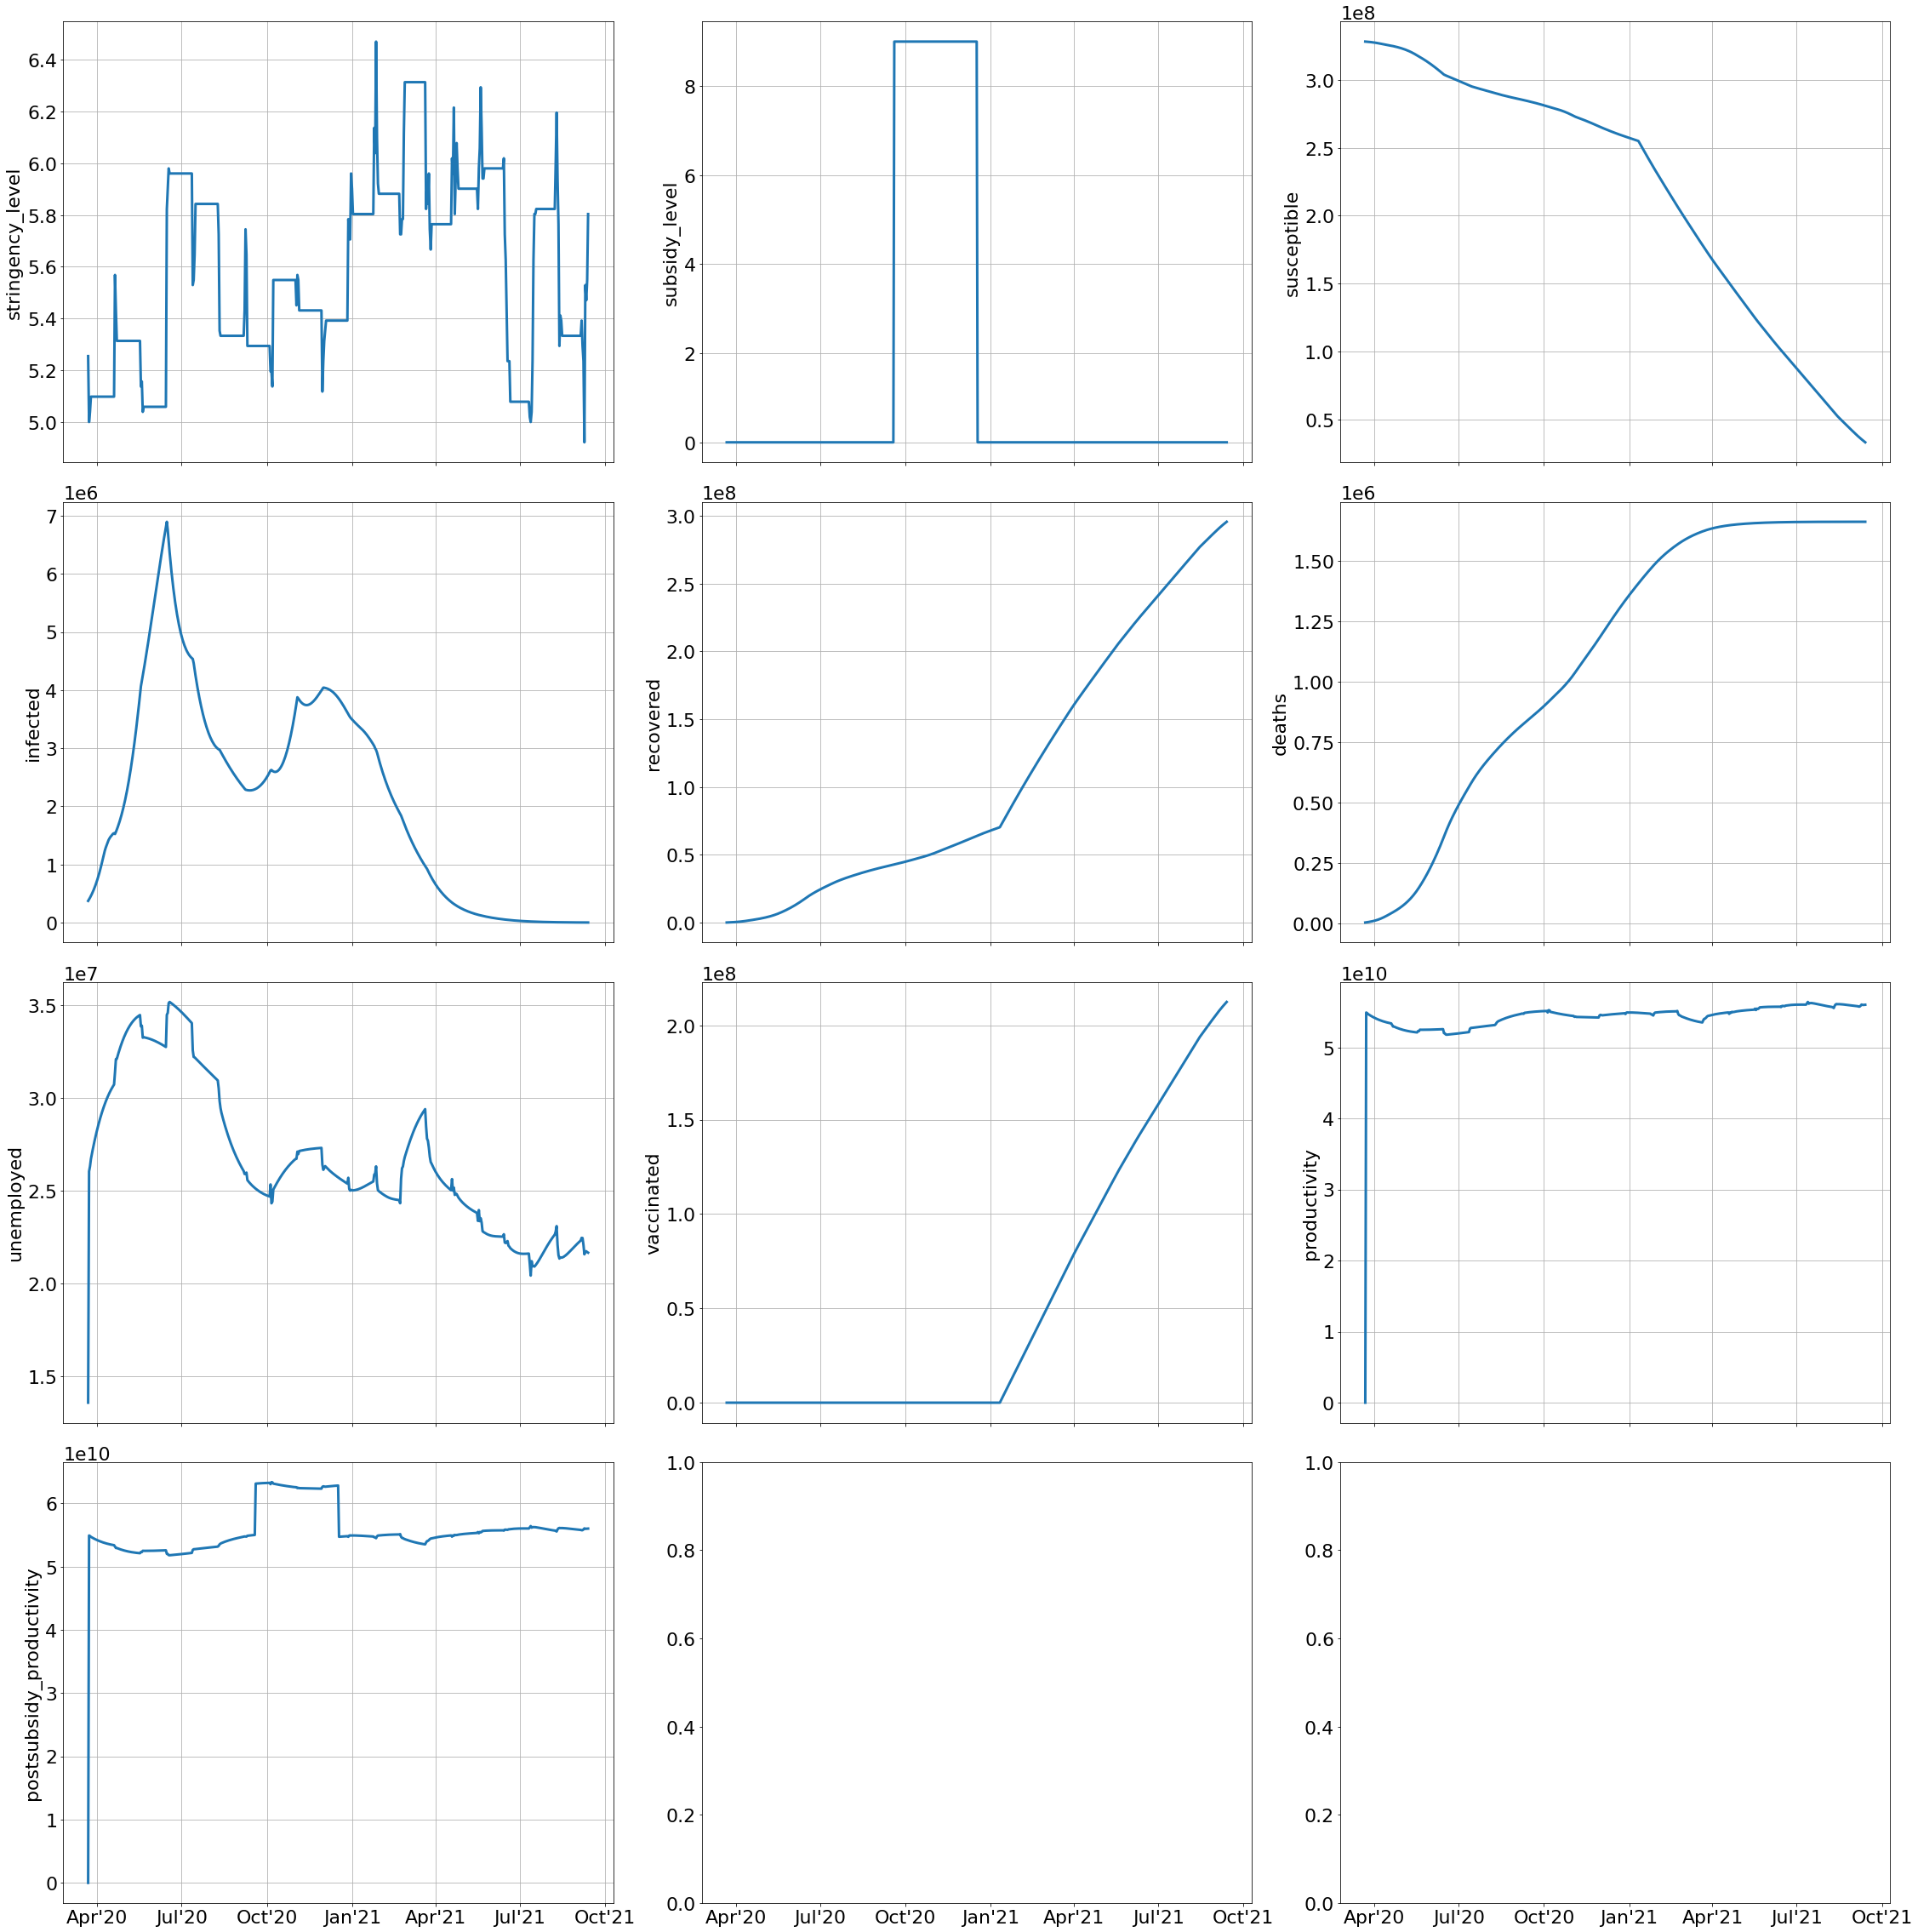

In [20]:
# Fetch the key state indicators for an episode.
episode_states = trainer.fetch_episode_states(
    [
        "stringency_level",
        "subsidy_level",        
        "susceptible",
        "infected",
        "recovered",
        "deaths",
        "unemployed",
        "vaccinated",
        "productivity",
        "postsubsidy_productivity",
    ]
)

# Visualize the fetched states for the USA.
# Feel free to modify the 'entity' argument to visualize the curves for the US states (e.g., California, Utah) too.
visualize_states(
    entity="USA",
    episode_states=episode_states,
    trainer=trainer,
)

And that's it for this tutorial. Happy training with Foundation and WarpDrive!